# Milestone P4 - A comparative approach on chilling effect, from Wikipedia to Google Trend

## Course CS-401 - Applied Data Analysis

### Instructor : [Robert West](https://dlab.epfl.ch/people/west/)

### Author :  
- **Chraibi Ghali**  
    SCIPER: 262251
- **Jesslen Artur**  
    SCIPER: 270642
- **Michels Luc**  
    SCIPER: 273666  

#### Due date: 18 Dec 2020

### Imports

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sn

from os import path
import json
import requests

from helper import *

data_path = "data/"
base_request_prefix = "https://kgsearch.googleapis.com/v1/entities:search"

---
### Context

Lorem ipsum

---
### Scrapping of the data

**> Wikipedia to google trends**

Using google trends instead of wikipedia has advantages and limitations (that will be discussed in the Discussion section). By using google trends, we can get location specific answers and also use language agnostic requests through topics. However, some limitations were introduced as google trends does not provide absolute article views numbers but instead gives normalized results based on the highest search count in the specified timeframe and location ([2]). In this section, we will explain how we obtained our google trends dataframes.

**Step 1: Article to Search term**

To reproduce the results obtained by Dr. Jonathon W. Penney ([9]) we first need to translate the terms from their respective DHS categories into google search terms. In most cases we can use the DHS terms directly. However if there are several terms to translate we use the one closest to the wikipedia article chosen by Dr Penney (ex: “Agent/Espionage” becomes “Espionage”) ([9]).  

**Step 2: Search term to topic**

Topics “are a group of terms that share the same concept in any language” ([4]) . This implies that the same terms but in different languages are also grouped together.

Now that we have search terms we want to use the topics they represent. If we directly use the DHS categories terms we will probably not obtain any correct results. Indeed, if we compare the interests for the search terms “Federal Bureau of Investigation” and “FBI” then we will see that the vast majority of internet surfers use “FBI” which should point to the same entity ([6]). Instead we can use freebase IDs which regroups the terms with the same meaning together and corresponds to the “topics” in google trends ([3]()).

However, the freebase API is no longer usable ([5]). We have to pass through the Google Knowledge Graph Search API instead. This API lets us search for all entities in the Google Knowledge graph and gives us the entities closest to the search term we input. Each entity has a “resultScore:	An indicator of how well the entity matched the request constraints.” ([7]). Then we can parse the best entity for its corresponding freebase id (sometimes GKG id ([1]).
However, by choosing the entity with the highest resultScore we had made the assumption none of our DHS terms are ambiguous and the closest match will always be the correct topic. This holds for most DHS terms but is not true for all. We then decided to individually fix those mismatched topics by finding the correct topic on google trends and dropping the term if no such topic existed. Also we found that “terror”  and “terrorism” both point to the "Terrorism" entity so we kept only “terrorism”.

| Original DHS Term     | Mismatched topic                                  | Replaced topic |
| --------------------- | ------------------------------------------------- | ------ |
| attack                | Attack on Titan                                   | Attack |
| Agro                  | Agronomy                                          | No terrorism topic found |
| Nuclear Enrichment    | International Conference on Nuclear Fuel Cycle…   | No terrorism topic found |
| Nuclear               | Magnetic resonance imaging                        | Nuclear weapon |
| Biological Weapon     | Biological Weapons Convention                     | biological weapon |
| FARC                  | Farce                                             | Revolutionary Armed Forces of Colombia—People's Army |
| Suicide bomber        | Female suicide bomber                             | No suicide bomber topic found |
| Pirates               | Pirates of the Caribbean: The Curse of the Bla…   | No terrorism topic found |
| Secret Service        | Kingsman: The Secret Service                      | United States Secret Service |
| Agro                  | Agronomy                                          | Agro-terrorism |


When using the GTab API (explained in next section), two of our queries returned with “bad response”. We decided to drop these topics as there were no suitable replacement topics.

In the end we were missing:

Terrorism category ( 6/ 48 ):  
Agro  
Nuclear Enrichment  
Suicide bomber  
Pirates  
Environmental Terrorism (*Bad response*)  
Terror (*Pointed to an already existing Topic*)  

Domestic category ( 1/ 25 ):  
Secure Border Initiative (*Bad response*)  

**Step 3: Google Trends Anchor Bank**

Now that we have topics we can directly use it to query any google trends API ([3]). However, as explained above, the results obtained are normalized and we can compare only up to 5 queries ([2]). This means that we cannot compare our results together as we don’t have the absolute values for each query and we have a minimum of 24 topics to compare. 

We can use the GTab API to bypass this problem. Indeed, GTab creates an offline anchor bank with a wide range of queries and one reference query. All subsequent queries are then compared to the closest stored query with a binary search which is in turn compared to the reference query. Therefore, all queries we make are relative to the reference query which means we can compare our queries together and we also remove rounding errors in the event we would be comparing topics with too large differences in popularity ([8]). 

**Step 4: Creating the dataframes**

We now have all the required tools for creating the dataframes. We start by creating the required anchor banks for GTab. We create two anchor banks with a US search location. 
Indeed, the original terms for the queries come from the DHS, the Department of Homeland Security. The terms which originate from this institution are mostly directed towards the American population. Most notably, the “domestic” category mainly uses US organisations (ex: DHS, FBI, CIA, etc).
Then we chose two timeframes: one for the paper timeframe (2012-01-01 -> 2014-08-31) and one that goes until the end of November 2020 (2012-01-01 -> 2020-11-30). Afterwards, we query google trends using the GTab API and the corresponding anchor bank.

The data frame created has following attributes:  

| Name | Description |
| ----------------- | ---------------- |
| Date          | Starting day of the week where the data is aggregated |
| max_ratio     | Calibrated value based on the reference query of the anchor bank (most popular query of the anchor bank) |
| max_ratio_hi  | Low error bound determined by gtab |
| max_ratio_lo  | High error bound determined by gtab |
| article_name  | Name of the original DHS term |


[1]: https://searchengineland.com/laymans-visual-guide-googles-knowledge-graph-search-api-241935

[2]: https://support.google.com/trends/answer/4365533?hl=en

[3]: https://trends.google.com/trends/explore?geo=US&q=%2Fm%2F02_1m

[4]: https://support.google.com/trends/answer/4359550

[5]: https://developers.google.com/freebase/v1/search

[6]: https://trends.google.com/trends/explore?geo=US&q=Federal%20Bureau%20of%20Investigation,fbi

[7]: https://developers.google.com/knowledge-graph/reference/rest/v1

[8]: https://arxiv.org/abs/2007.13861

[9]: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2769645

**Step 0: Verify functioning of the API**

In [2]:
MAPPING = False
if MAPPING: 
    # Read API_key (you need your own key for it to work)
    with open(data_path + "API_key","r") as f:
        API_key = f.read()
    # Create simple request to show structure and test if functional
    params = {
        "query" : "iraq",
        "key"   : API_key,
        "limit" : 1,  
        "indent": True
    }
    r = requests.get(base_request_prefix, params = params)
    entity = r.json()
    print(f"JSON structure returned by the API:\n{get_json_structure(entity)}")


**Step 1: Article to Search term**


In [3]:
# Print 
search_queries = load_pickle(data_path + 'search_queries.pkl')
for key, value in search_queries.items():
    print(f"{key}:\n{value}\n")

terrorism:
['Al-Qaeda', 'terrorism', 'terror', 'attack', 'iraq', 'afghanistan', 'iran', 'Pakistan', 'Agro', 'Environmental Terrorism', 'Eco-Terrorism', 'Conventional Weapon', 'Weapons Grade', 'Dirty Bomb', 'Nuclear Enrichment', 'Nuclear', 'Chemical Weapon', 'Biological Weapon', 'Ammonium nitrate', 'Improvised Explosive Device', 'Abu Sayyaf', 'Hamas', 'FARC', 'Irish Republican Army', 'Euskadi ta Askatasuna ', 'Hezbollah', 'Tamil Tigers', 'PLO', 'Palestine Liberation Front', 'Car bomb', 'Jihad', 'Taliban', 'Suicide bomber', 'Suicide attack', 'AL Qaeda in the Arabian Peninsula', 'Al Qaeda in the Islamic Maghreb', 'Tehrik-i-Taliban Pakistan', 'Yemen', 'Pirates', 'Extremism', 'Somalia', 'Nigeria', 'Political radicalism', 'Al-Shabaab', 'Nationalism', 'Recruitment', 'Fundamentalism', 'Islamist']

top_30_terrorism:
['Al Qaeda', 'Terrorism', 'Terror', 'Environmental Terrorism', 'Eco-terrorism', 'Conventional Weapon', 'Weapons Grade', 'Dirty Bomb', 'Nuclear Enrichment', 'Nuclear', 'Chemical Weap

**Step 2: Search term to topic**

In [4]:
if MAPPING:
    # Terrorism dataset Mapping
    terrorism_mapping_df = create_search_terms_to_GKG_node_df(search_queries['terrorism'], 
        "terrorism", API_key)
    top_30_terrorism_mapping_df = create_search_terms_to_GKG_node_df(search_queries['top_30_terrorism'], 
        "top_30_terrorism", API_key)
    # Create id replacement dictionary
    id_replacement = {
        "/m/0gtxdb2" : "/g/11bc5q9v7r",
        "/m/04xkp"   : "/m/05gpf",
        "/m/01xmw0"  : "/g/121x751y",
        "/m/011ys5"  : "/m/06hvg",
        "/m/019jkv"  : "/m/0gggw2"

    }

    # Create name replacement dictionary
    name_replacement = {
        "Attack on Titan" : "Attack",
        "Magnetic resonance imaging" : "Nuclear weapon",
        "Biological Weapons Convention" : "biological weapon",
        "Farce" : "Revolutionary Armed Forces of Colombia—People's Army",
        "Agronomy" : "Agro-terrorism"

    }

    # Create list of topics ids to delete
    topics_id_to_delete = [
        "/g/11k69f5spb",
        "/g/11cr_hd3g5",
        "/m/01vksx",
        "/m/0jz65"
    ]
    # Fix ambiguous topics
    terrorism_mapping_df = fix_topics(terrorism_mapping_df, id_replacement, 
        name_replacement, topics_id_to_delete)
    top_30_terrorism_mapping_df = fix_topics(top_30_terrorism_mapping_df, 
        id_replacement, name_replacement, topics_id_to_delete)

In [5]:
if MAPPING:
    domestic_mapping_df = create_search_terms_to_GKG_node_df(search_queries['domestic'], "domestic", API_key)
    # Create id replacement dictionary
    domestic_id_replacement = { "/m/0y4n5ll" : "/m/0fynw"}
    # Create name replacement dictionary
    domestic_name_replacement = {"Kingsman: The Secret Service" : "United States Secret Service"}
    # Fix ambiguous topics
    domestic_mapping_df = fix_topics(domestic_mapping_df, domestic_id_replacement, domestic_name_replacement, [])

In [6]:
if MAPPING:
    all_mappings = [terrorism_mapping_df, domestic_mapping_df, top_30_terrorism_mapping_df]
    # Concatenate all mappings into one dataframe
    all_mappings_df = pd.concat(all_mappings).reset_index(drop=True)
    # Save dataframe to pickle
    all_mappings_df.to_pickle(data_path+"mapping.pkl")

#### Step 3 & 4: Google Trends Anchor Bank and creation of the dataframes

In [7]:
def create_dataframe(domain_name, geo, t):
    """
    Creates a dataframe concatenating all search queries interest over time data from google
    trends for one domain. The search queries will use the corresponding topics to the DHS category for the domain.
    Prints parametters of queries who failed.
    The returned dataframe has attributes:
    {date, max_ratio, max_ratio_hi, max_ratio_l, article_name, topic_name, topic_id, geo}

    Args:
        domain_name (str): domain of the search queries (ie. terrorims, domestic, top_30_terrorism)       
        geo (str): geolocalisation of the search query
        t (GTAB): GoogleTrendsAnchorBank to use for the queries it needs to be consistent with the geo parameter

    Returns:
        dataframe: dataframe concatenating all search queries interest over time data from google trends

    """
    mapping_df = load_pickle(data_path+"mapping.pkl")
    
    # Get the list of the article names of this domain 
    topic_queries_articles = mapping_df[mapping_df["domain_name"] == domain_name]["search_term"].tolist()
    # Get the list of topic ids of this domain 
    topic_queries_ids = mapping_df[mapping_df["domain_name"] == domain_name]["entity_id"].tolist()
    # Get the list of topic names of this domain 
    topic_queries_name = mapping_df[mapping_df["domain_name"] == domain_name]["entity_name"].tolist()
    
    # For each search query freebase id create the corresponding interest over time google trends data
    all_interest_over_time_dfs = [t.new_query(search_query) for search_query in topic_queries_ids]
    
    # Find all queries who succeeded                 
    successful_queries = [type(df) != type(-1) for df in all_interest_over_time_dfs]
    
    df_to_concatenate = []
    # Append the name and location to all dataframes
    for i, df in enumerate(all_interest_over_time_dfs):
        
        # Was it a successful query
        if successful_queries[i]:
            
            # Add the article name collumn 
            df["article_name"] = [topic_queries_articles[i]]*len(df)
            # Add the topic name collumn 
            df["topic_id"] = [topic_queries_ids[i]]*len(df)
            # Add the topic id collumn 
            df["topic_name"] = [topic_queries_name[i]]*len(df)
            # Add the localisation collumn
            df["geo"] = ["worldwide" if geo == "" else geo]*len(df)
            
            df_to_concatenate.append(df)
            
        # If not we print the parametters that failed
        else:
            print("Found a failed query")
            print(f"Article name: {topic_queries_articles[i]}")
            print(f"Topic name: {topic_queries_name[i]}")
            print(f"Topic id: {topic_queries_ids[i]}")
    
    # Concatenate all dfs into one centrale one
    return pd.concat(df_to_concatenate).reset_index()
    
def get_topics(domain_name, data_path):
    """Gives the list of all topics corresponding to the search queries for the specific domain.
    
    Args:
         domain_name (str): domain name of the search queries (i.e: terrorism, domestic, top_30_terrorism)
         data_path (str): directory path containing the mapping pickle file 
    
    Returns:
        list of all topics for this domain
    """
    mapping_df = load_pickle(data_path+"mapping.pkl")
    
    return mapping_df[mapping_df["domain_name"] == domain_name]["entity_id"].tolist()

In [8]:
CREATE_DATAFRAMES = False
if CREATE_DATAFRAMES:
    # We choose the US geolocalisation because categories are from the DHS
    for geo in ["US", "CA", "GB", "AU", "CH"]:

        # Create time frame corresponding to the paper study
        start_timeframe = "2012-01-01"
        end_timeframe   = "2014-08-31"

        t = create_and_set_gtab(start_timeframe, end_timeframe, geo)

        # Create terrorism dataframe
        terrorism_df = create_dataframe("terrorism", geo, t)
        # Create domestic dataframe
        domestic_df = create_dataframe("domestic", geo, t)
        # Create top-30 terrorism dataframe
        top_30_terrorism_df = create_dataframe("top_30_terrorism", geo, t)
        # Save dataframes to pickle
        terrorism_df.to_pickle(data_path+f"terrorism_{geo}.pkl")
        domestic_df.to_pickle(data_path+f"domestic_{geo}.pkl")
        top_30_terrorism_df.to_pickle(data_path+f"top_30_terrorism_{geo}.pkl")
        
        # ---------------------------------------------------------------

        # Set start to paper start timeframe and end to present time (Stop at November 2020)
        start_timeframe = "2012-01-01"
        end_timeframe   = "2020-11-30"

        t = create_and_set_gtab(start_timeframe, end_timeframe, geo)

        # Create terrorism dataframe
        terrorism_df = create_dataframe("terrorism", geo, t)
        # Create domestic dataframe
        domestic_df = create_dataframe("domestic", geo, t)
        # Create top-30 terrorism dataframe
        top_30_terrorism_df = create_dataframe("top_30_terrorism", geo, t)
        # Save dataframe to pickle
        terrorism_df.to_pickle(data_path+f"terrorism_present_{geo}.pkl")
        domestic_df.to_pickle(data_path+f"domestic_present_{geo}.pkl")
        top_30_terrorism_df.to_pickle(data_path+f"top_30_terrorism_present_{geo}.pkl")

---
### Replicate the experiment of the paper

#### Load data

In [9]:
data_path = 'data/'

if path.exists(data_path):
    terrorism_df = load_pickle(data_path+"terrorism_US.pkl")
    domestic_df = load_pickle(data_path+"domestic_US.pkl")
    terrorism30_df = load_pickle(data_path+"top_30_terrorism_US.pkl")
else:
    raise NotADirectoryError

In [10]:
terrorism_df = terrorism_df[['date', 'max_ratio', 'topic_name']]
terrorism30_df = terrorism30_df[['date', 'max_ratio', 'topic_name']]
domestic_df = domestic_df[['date', 'max_ratio', 'topic_name']]

In [11]:
print(terrorism_df.shape)
terrorism_df.head(5)

(5880, 3)


,date,max_ratio,topic_name
0,2012-01-01,1.033386,Al-Qaeda
1,2012-01-08,1.351351,Al-Qaeda
2,2012-01-15,1.351351,Al-Qaeda
3,2012-01-22,1.192369,Al-Qaeda
4,2012-01-29,1.430843,Al-Qaeda


In [12]:
print(terrorism30_df.shape)
terrorism_df.head(5)

(3640, 3)


,date,max_ratio,topic_name
0,2012-01-01,1.033386,Al-Qaeda
1,2012-01-08,1.351351,Al-Qaeda
2,2012-01-15,1.351351,Al-Qaeda
3,2012-01-22,1.192369,Al-Qaeda
4,2012-01-29,1.430843,Al-Qaeda


In [13]:
print(domestic_df.shape)
terrorism_df.head(5)

(3220, 3)


,date,max_ratio,topic_name
0,2012-01-01,1.033386,Al-Qaeda
1,2012-01-08,1.351351,Al-Qaeda
2,2012-01-15,1.351351,Al-Qaeda
3,2012-01-22,1.192369,Al-Qaeda
4,2012-01-29,1.430843,Al-Qaeda


#### Analyse data

In [14]:
# Define a constant for the date of revelation
revelation_date = pd.Timestamp('2013-06-15')

In [15]:
#domestic_df = domestic_df[~(domestic_df['topic_name']== 'Federal Bureau of Investigation')]
#set(domestic_df['topic_name'])

Step 1

In [16]:
# Organise the data in a time series with the ratio of total views per week
terrorism_ts = terrorism_df.groupby(by='date').sum()
terrorism_ts = terrorism_ts.reset_index().rename(columns={'index': 'date'})

# Separate the data in two to perform an ITS analysis
terrorism_pre_june_ts = terrorism_ts[terrorism_ts['date'] < revelation_date]
terrorism_post_june_ts = terrorism_ts[terrorism_ts['date'] > revelation_date]

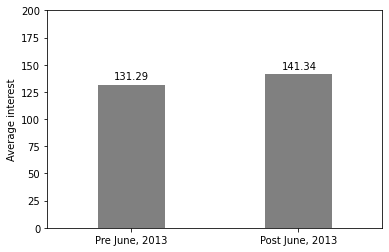

In [17]:
mean_pre_june = np.mean(terrorism_pre_june_ts['max_ratio'])
mean_post_june = np.mean(terrorism_post_june_ts['max_ratio'])
plt.bar([0, 1], [mean_pre_june, mean_post_june], color='gray', width=0.4)
plt.xticks([0, 1], ['Pre June, 2013', 'Post June, 2013'])
plt.ylabel("Average interest")
plt.xlim(-0.5, 1.5)
plt.ylim(0, 200)
plt.text(-0.1, mean_pre_june + 5, f"{mean_pre_june:.2f}")
plt.text(0.9, mean_post_june + 5, f"{mean_post_june:.2f}")
plt.show()

Step 2.1 - Show regression for terrorism

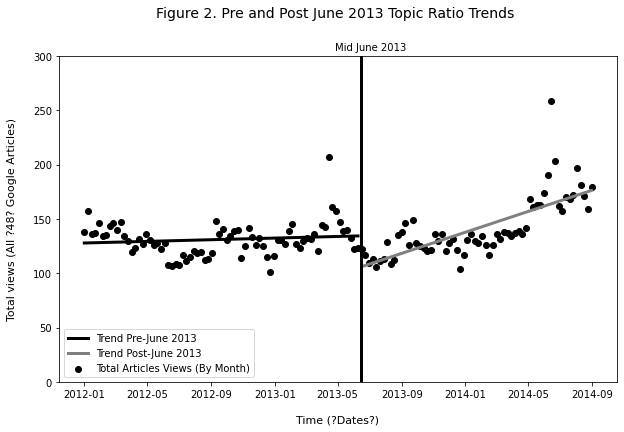

In [18]:
### TODO Modify description of the plot

# Visualisation of full time series
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Figure 2. Pre and Post June 2013 Topic Ratio Trends \n\n', fontsize=14)
ax.set_xlabel('\nTime (?Dates?)', fontsize=11)
ax.set_ylabel('Total views (All ?48? Google Articles)\n', fontsize=11)
ax.set_ylim(0, 300)

ax.scatter(terrorism_ts.date, terrorism_ts['max_ratio'], 
    label='Total Articles Views (By Month)', color='black')

# Draw the regressions
slope_pre_june, intercept_pre_june, _, _, _ = stats.linregress(terrorism_pre_june_ts.index, 
                                                               terrorism_pre_june_ts['max_ratio'])
slope_post_june, intercept_post_june, _, _, _ = stats.linregress(terrorism_post_june_ts.index,
                                                                 terrorism_post_june_ts['max_ratio'])
x1 = terrorism_pre_june_ts.index
ax.plot(terrorism_pre_june_ts.date, intercept_pre_june + slope_pre_june*x1, 
    color='black', linewidth='3', label='Trend Pre-June 2013')
x2 = terrorism_post_june_ts.index
ax.plot(terrorism_post_june_ts.date, intercept_post_june + slope_post_june*x2, 
    color='gray', linewidth='3', label='Trend Post-June 2013')

# Emphasise when the revelations occured 
ax.axvline(x=revelation_date, ymin=0, ymax=280, color='black', linewidth='3')

x_text_offset = revelation_date - pd.Timedelta(50, 'd')
y_text_offset = 305
ax.text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)

ax.legend(loc='lower left')
plt.show()

Step 2.2 - Remove outliers

We observe that the graph above contains some outliers that may alter our analysis

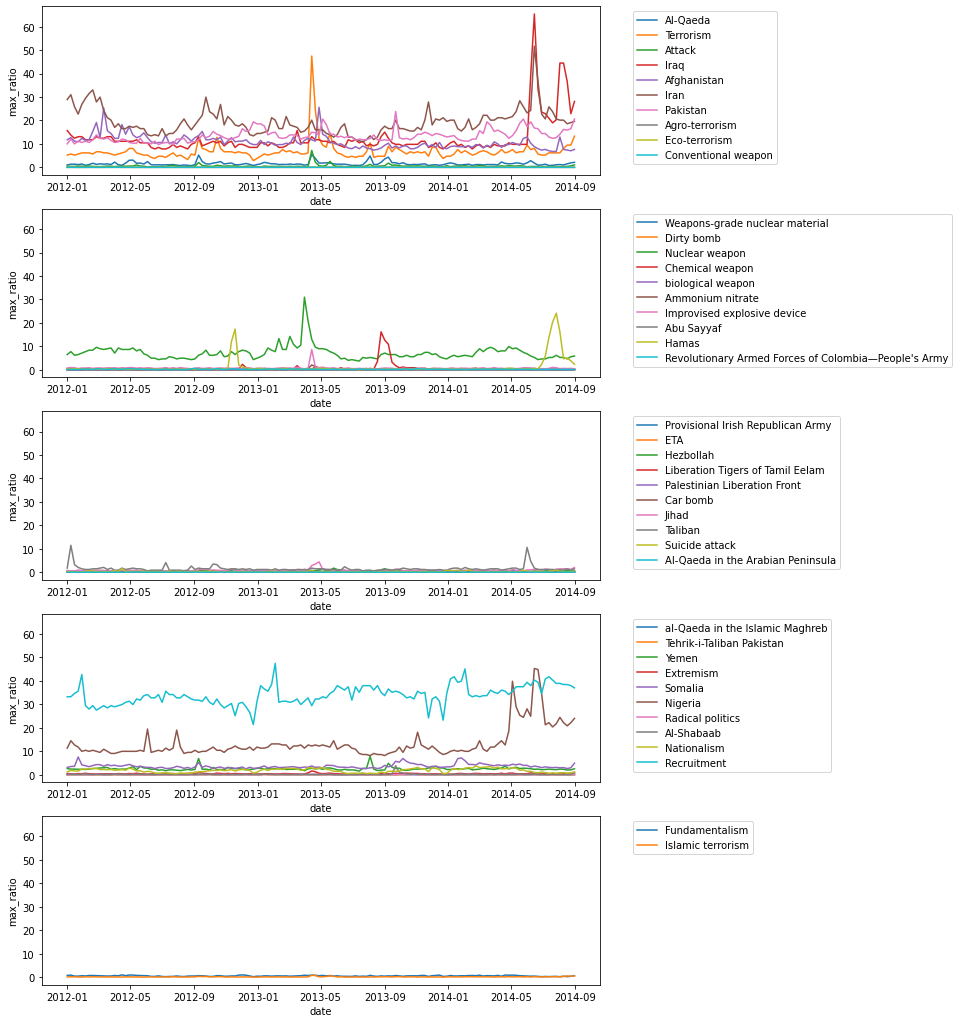

In [19]:
fig, ax = plt.subplots(5, 1, figsize=(10, 18), sharey=True)

points_per_topic = len(terrorism_df)/len(set(terrorism_df['topic_name']))
topics_per_plot = 10
points_per_plot = points_per_topic * topics_per_plot

for i in range(5):
    sn.lineplot(data=terrorism_df[i*int(points_per_plot):(i+1)*int(points_per_plot)], 
                x='date', 
                y='max_ratio', 
                hue='topic_name', 
                ax=ax[i])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [20]:
terrorism_df = terrorism_df[~(terrorism_df['topic_name']== 'Iraq')]
terrorism_df = terrorism_df[~(terrorism_df['topic_name']== 'Terrorism')]
terrorism_df = terrorism_df[~(terrorism_df['topic_name']== 'Nigeria')]
terrorism_df = terrorism_df[~(terrorism_df['topic_name']== 'Nuclear weapon')]
terrorism_df = terrorism_df[~(terrorism_df['topic_name']== 'Hamas')]
terrorism_df = terrorism_df[~(terrorism_df['topic_name']== 'Chemical weapon')]

In [21]:
# Organise the data in a time series with the ratio of total views per week
terrorism_ts = terrorism_df.groupby(by='date').sum()
terrorism_ts = terrorism_ts.reset_index().rename(columns={'index': 'date'})

# Separate the data in two to perform an ITS analysis
terrorism_pre_june_ts = terrorism_ts[terrorism_ts['date'] < revelation_date]
terrorism_post_june_ts = terrorism_ts[terrorism_ts['date'] > revelation_date]

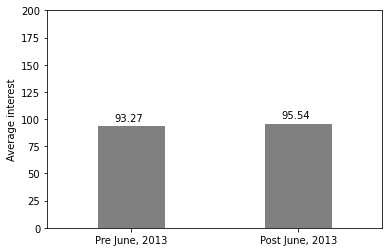

In [22]:
mean_pre_june = np.mean(terrorism_pre_june_ts['max_ratio'])
mean_post_june = np.mean(terrorism_post_june_ts['max_ratio'])
plt.bar([0, 1], [mean_pre_june, mean_post_june], color='gray', width=0.4)
plt.xticks([0, 1], ['Pre June, 2013', 'Post June, 2013'])
plt.ylabel("Average interest")
plt.xlim(-0.5, 1.5)
plt.ylim(0, 200)
plt.text(-0.1, mean_pre_june + 5, f"{mean_pre_june:.2f}")
plt.text(0.9, mean_post_june + 5, f"{mean_post_june:.2f}")
plt.show()

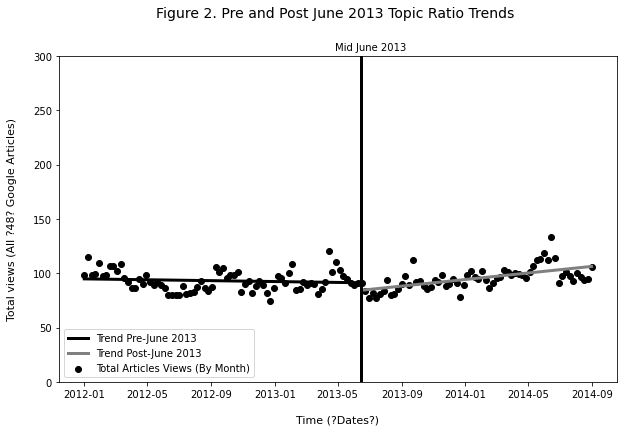

In [23]:
### TODO Modify description of the plot

# Visualisation of full time series
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Figure 2. Pre and Post June 2013 Topic Ratio Trends \n\n', fontsize=14)
ax.set_xlabel('\nTime (?Dates?)', fontsize=11)
ax.set_ylabel('Total views (All ?48? Google Articles)\n', fontsize=11)
ax.set_ylim(0, 300)

ax.scatter(terrorism_ts.date, terrorism_ts['max_ratio'], 
    label='Total Articles Views (By Month)', color='black')

# Draw the regressions
slope_pre_june, intercept_pre_june, _, _, _ = stats.linregress(terrorism_pre_june_ts.index, 
                                                               terrorism_pre_june_ts['max_ratio'])
slope_post_june, intercept_post_june, _, _, _ = stats.linregress(terrorism_post_june_ts.index,
                                                                 terrorism_post_june_ts['max_ratio'])
x1 = terrorism_pre_june_ts.index
ax.plot(terrorism_pre_june_ts.date, intercept_pre_june + slope_pre_june*x1, 
    color='black', linewidth='3', label='Trend Pre-June 2013')
x2 = terrorism_post_june_ts.index
ax.plot(terrorism_post_june_ts.date, intercept_post_june + slope_post_june*x2, 
    color='gray', linewidth='3', label='Trend Post-June 2013')

# Emphasise when the revelations occured 
ax.axvline(x=revelation_date, ymin=0, ymax=280, color='black', linewidth='3')

x_text_offset = revelation_date - pd.Timedelta(50, 'd')
y_text_offset = 305
ax.text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)

ax.legend(loc='lower left')
plt.show()

Step 3.1 - Compare with dommestic

In [24]:
# Organise the data in time series with the ratio of total views per week
terrorism30_ts = terrorism30_df.groupby(by='date').sum()
terrorism30_ts = terrorism30_ts.reset_index().rename(columns={'index': 'date'})

domestic_ts = domestic_df.groupby(by='date').sum()
domestic_ts = domestic_ts.reset_index().rename(columns={'index': 'date'})

# Separate the data in two to perform an ITS analysis
terrorism30_pre_june_ts = terrorism30_ts[terrorism30_ts['date'] < revelation_date]
terrorism30_post_june_ts = terrorism30_ts[terrorism30_ts['date'] > revelation_date]

domestic_pre_june_ts = domestic_ts[domestic_ts['date'] < revelation_date]
domestic_post_june_ts = domestic_ts[domestic_ts['date'] > revelation_date]

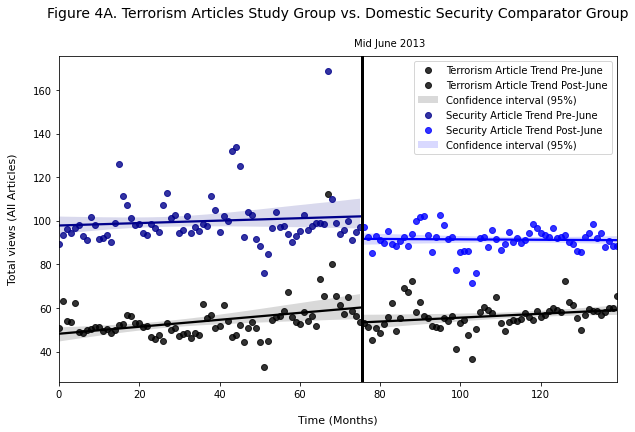

In [25]:
### Show the final figure with both terrorism articles study group and the comparator group
## Visualisation of the full time series
fig, ax = plt.subplots(figsize=(10, 6))

## Draw the data points, regressions & CIs
# on terrorism data (pre/post june)
x1 = terrorism30_pre_june_ts.index
y1 = terrorism30_pre_june_ts['max_ratio']
sn.regplot(x=x1, y=y1, data=terrorism30_pre_june_ts, color="black",
           label="Terrorism Article Trend Pre-June", scatter=True, n_boot=10000, ax=ax)

x2 = terrorism30_post_june_ts.index
y2 = terrorism30_post_june_ts['max_ratio']
sn.regplot(x=x2, y=y2, data=terrorism30_post_june_ts, color="black",
           label="Terrorism Article Trend Post-June", scatter=True, n_boot=10000, ax=ax)

# on domestic security data (pre/post june)
x1 = domestic_pre_june_ts.index
y1 = domestic_pre_june_ts['max_ratio']
sn.regplot(x=x1, y=y1, data=domestic_pre_june_ts, color="darkblue",
           label="Security Article Trend Pre-June", scatter=True, n_boot=10000, ax=ax)

x2 = domestic_post_june_ts.index
y2 = domestic_post_june_ts['max_ratio']
sn.regplot(x=x2, y=y2, data=domestic_post_june_ts, color="blue",
           label="Security Article Trend Post-June", scatter=True, n_boot=10000, ax=ax)

# Emphasise when the revelations occured 
revelation_date_integer = 75.5
ax.axvline(x=revelation_date_integer, ymin=0, ymax=160, color='black', linewidth='3')

x_text_offset = revelation_date_integer - 2
y_text_offset = 180
ax.text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)

ax.collections[3].set_label('Confidence interval (95%)')
ax.collections[7].set_label('Confidence interval (95%)')

ax.set_title('Figure 4A. Terrorism Articles Study Group vs. Domestic Security Comparator Group\n\n', fontsize=14)
ax.set_xlabel('\nTime (Months)', fontsize=11)
ax.set_ylabel('Total views (All Articles)\n', fontsize=11)
ax.legend(loc='upper right')

plt.show()

Step 3.2 - Look for outliers

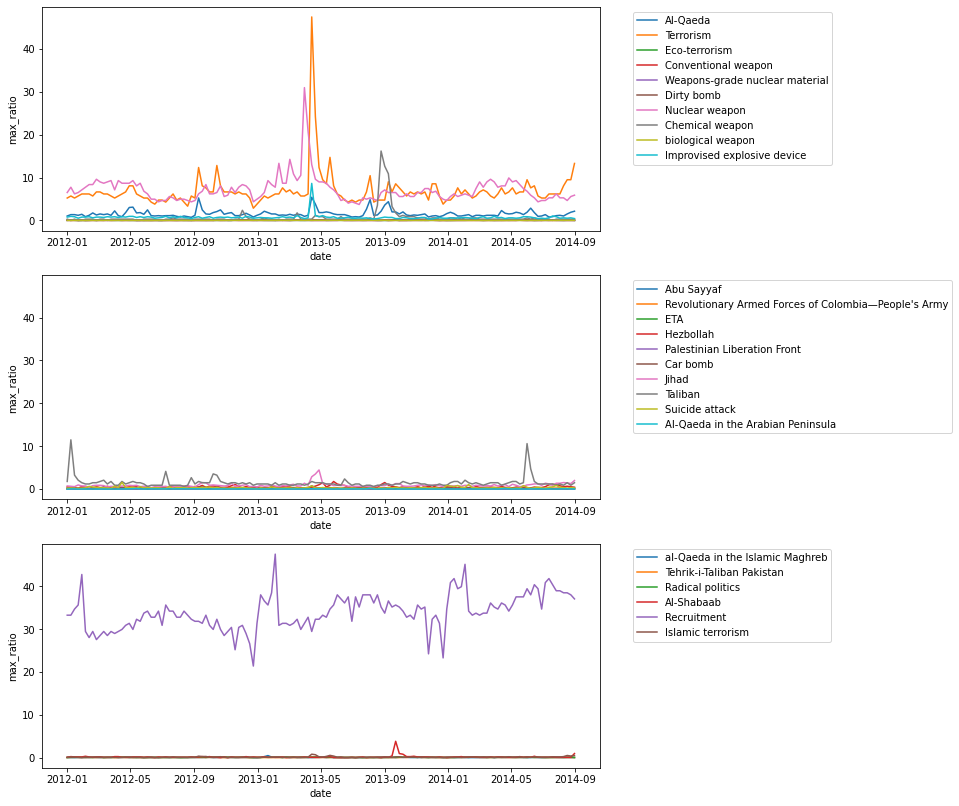

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(10, 14), sharey=True)

points_per_topic = len(terrorism30_df)/len(set(terrorism30_df['topic_name']))
topics_per_plot = 10
points_per_plot = points_per_topic * topics_per_plot

for i in range(3):
    sn.lineplot(data=terrorism30_df[i*int(points_per_plot):(i+1)*int(points_per_plot)], 
                x='date', 
                y='max_ratio', 
                hue='topic_name', 
                ax=ax[i])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [27]:
len(set(terrorism30_df['topic_name']))//topics_per_plot + 1

3

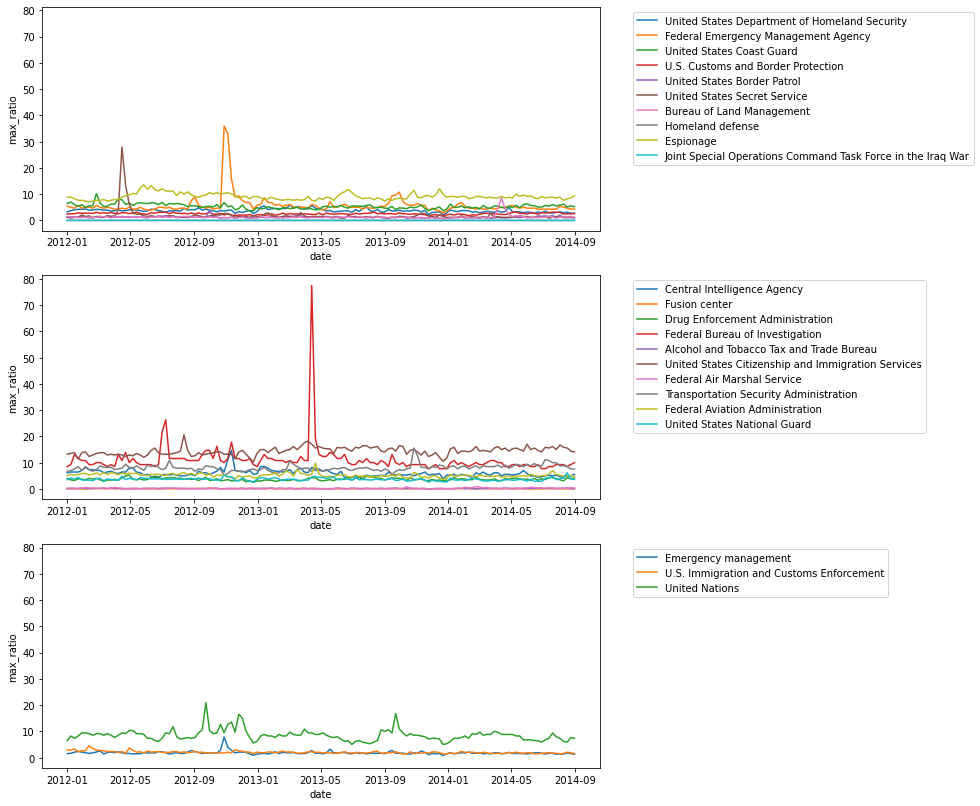

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(10, 14), sharey=True)

points_per_topic = len(domestic_df)/len(set(domestic_df['topic_name']))
topics_per_plot = 10
points_per_plot = points_per_topic * topics_per_plot

for i in range(3):
    sn.lineplot(data=domestic_df[i*int(points_per_plot):(i+1)*int(points_per_plot)], 
                x='date', 
                y='max_ratio', 
                hue='topic_name', 
                ax=ax[i])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [29]:
terrorism30_df = terrorism30_df[~(terrorism30_df['topic_name']== 'Terrorism')]
terrorism30_df = terrorism30_df[~(terrorism30_df['topic_name']== 'Nuclear weapon')]
terrorism30_df = terrorism30_df[~(terrorism30_df['topic_name']== 'Chemical weapon')]

domestic_df = domestic_df[~(domestic_df['topic_name']== 'Federal Bureau of Investigation')]
domestic_df = domestic_df[~(domestic_df['topic_name']== 'Federal Emergency Management Agency')]
domestic_df = domestic_df[~(domestic_df['topic_name']== 'United States Secret Service')]

In [30]:
# Organise the data in time series with the ratio of total views per week
terrorism30_ts = terrorism30_df.groupby(by='date').sum()
terrorism30_ts = terrorism30_ts.reset_index().rename(columns={'index': 'date'})

domestic_ts = domestic_df.groupby(by='date').sum()
domestic_ts = domestic_ts.reset_index().rename(columns={'index': 'date'})

# Separate the data in two to perform an ITS analysis
terrorism30_pre_june_ts = terrorism30_ts[terrorism30_ts['date'] < revelation_date]
terrorism30_post_june_ts = terrorism30_ts[terrorism30_ts['date'] > revelation_date]

domestic_pre_june_ts = domestic_ts[domestic_ts['date'] < revelation_date]
domestic_post_june_ts = domestic_ts[domestic_ts['date'] > revelation_date]

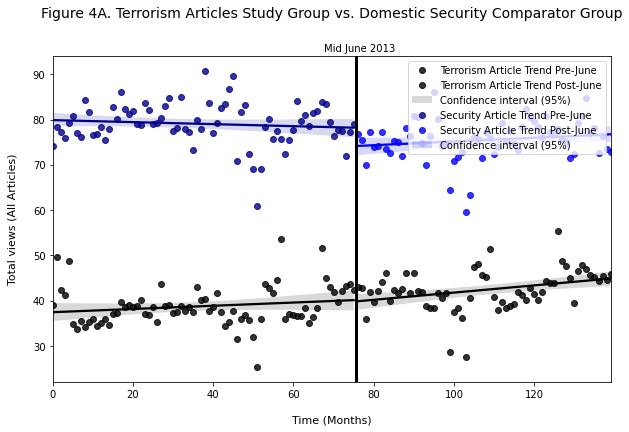

In [31]:
### Show the final figure with both terrorism articles study group and the comparator group
## Visualisation of the full time series
fig, ax = plt.subplots(figsize=(10, 6))

## Draw the data points, regressions & CIs
# on terrorism data (pre/post june)
x1 = terrorism30_pre_june_ts.index
y1 = terrorism30_pre_june_ts['max_ratio']
sn.regplot(x=x1, y=y1, data=terrorism30_pre_june_ts, color="black",
           label="Terrorism Article Trend Pre-June", scatter=True, n_boot=10000, ax=ax)

x2 = terrorism30_post_june_ts.index
y2 = terrorism30_post_june_ts['max_ratio']
sn.regplot(x=x2, y=y2, data=terrorism30_post_june_ts, color="black",
           label="Terrorism Article Trend Post-June", scatter=True, n_boot=10000, ax=ax)

# on domestic security data (pre/post june)
x1 = domestic_pre_june_ts.index
y1 = domestic_pre_june_ts['max_ratio']
sn.regplot(x=x1, y=y1, data=domestic_pre_june_ts, color="darkblue",
           label="Security Article Trend Pre-June", scatter=True, n_boot=10000, ax=ax)

x2 = domestic_post_june_ts.index
y2 = domestic_post_june_ts['max_ratio']
sn.regplot(x=x2, y=y2, data=domestic_post_june_ts, color="blue",
           label="Security Article Trend Post-June", scatter=True, n_boot=10000, ax=ax)

# Emphasise when the revelations occured 
revelation_date_integer = 75.5
ax.axvline(x=revelation_date_integer, ymin=0, ymax=90, color='black', linewidth='3')

x_text_offset = revelation_date_integer - 8
y_text_offset = 95
ax.text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)

ax.collections[3].set_label('Confidence interval (95%)')
ax.collections[7].set_label('Confidence interval (95%)')

ax.set_title('Figure 4A. Terrorism Articles Study Group vs. Domestic Security Comparator Group\n\n', fontsize=14)
ax.set_xlabel('\nTime (Months)', fontsize=11)
ax.set_ylabel('Total views (All Articles)\n', fontsize=11)
ax.legend(loc='upper right')

plt.show()

### Discussion:  
#### Limitations of our approach: 

1. Locality and different reference point:  
GTab still has some limitations. Indeed, we can only compare queries as long as they use the same anchorbank. If we want to query google trends for different countries we have to use different anchor banks. This means that we cannot quantitatively compare results for different countries. However, we can still offer qualitative insight based on our results. For instance positive trends will stay positive with any reference point.